# Train Transformer
This notebook trains the Transformer and embeds it in a translator class. It is based on the [Neural Machine Translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer) tutorial by TensorFlow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_text as text
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import config

## Dataset and tokenizers
Load dataset and tokenizers, see the tokenization notebook for details. Plot the distribution of tokens per sentence.

In [4]:
train_dataset = tf.data.Dataset.load(config.TRAIN_DATA_PATH)
val_dataset = tf.data.Dataset.load(config.VAL_DATA_PATH)
tokenizers = tf.saved_model.load(config.TOKENIZER_PATH)

In [5]:
lengths = []

for batch in train_dataset.take(50_000).batch(1024):
    eng_tokens = tokenizers.eng.tokenize(batch[:, 0])
    lengths.append(eng_tokens.row_lengths())
    nor_tokens = tokenizers.nor.tokenize(batch[:, 1])
    lengths.append(nor_tokens.row_lengths())

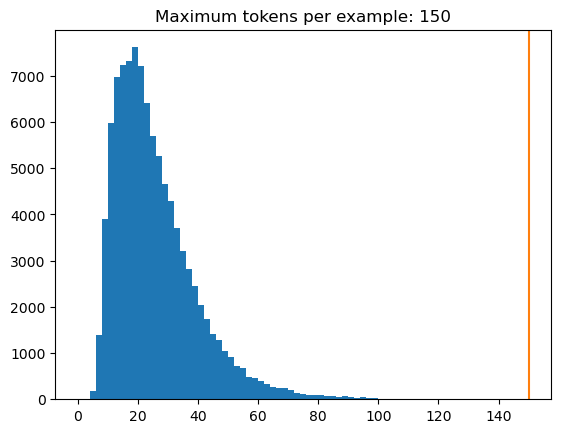

In [6]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 100, 51))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f"Maximum tokens per example: {max_length}");

## Batches
Split the tokenized dataset into batches for model training.

In [7]:
def prepare_batch(batch):
    eng = batch[:, 0]
    eng = tokenizers.eng.tokenize(eng)  # Output is ragged.
    eng = eng[:, : config.MAX_TOKENS]  # Trim to MAX_TOKENS.
    eng = eng.to_tensor()  # Convert to 0-padded dense Tensor

    nor = batch[:, 1]
    nor = tokenizers.nor.tokenize(nor)
    nor = nor[:, : (config.MAX_TOKENS + 1)]
    nor_inputs = nor[:, :-1].to_tensor()  # Drop the [END] tokens
    nor_labels = nor[:, 1:].to_tensor()  # Drop the [START] tokens

    return (eng, nor_inputs), nor_labels


def make_batches(ds):
    return (
        ds.batch(config.BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [8]:
val_batches = make_batches(val_dataset)
train_batches = make_batches(train_dataset)

## Transformer
Compile and train the Transformer model.

In [9]:
from model import Transformer, masked_loss, masked_accuracy, CustomSchedule

transformer = Transformer(
    num_layers=config.N_LAYERS,
    d_model=config.D_MODEL,
    num_heads=config.N_HEADS,
    dff=config.FFN_DIM,
    input_vocab_size=config.VOCAB_SIZE,
    target_vocab_size=config.VOCAB_SIZE,
    dropout_rate=config.DROPOUT_RATE,
)

In [10]:
# Build the transformer by applying it to a sample
for (eng, nor), nor_labels in train_batches.take(1):
    break
transformer((eng, nor))
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1308160   
                                                                 
 decoder (Decoder)           multiple                  1839360   
                                                                 
 dense_16 (Dense)            multiple                  520000    
                                                                 
Total params: 3667520 (13.99 MB)
Trainable params: 3667520 (13.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
from model import CustomSchedule

learning_rate = CustomSchedule(config.D_MODEL)
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate, **config.OPTIMIZER_KWARGS
)

Text(0.5, 0, 'Train Step')

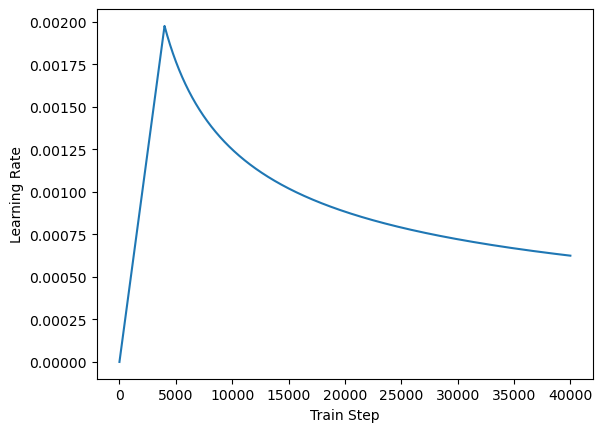

In [12]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [13]:
from model import masked_loss, masked_accuracy

transformer.compile(
    loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy]
)

In [14]:
transformer.fit(
    train_batches, epochs=config.N_EPOCHS, validation_data=val_batches
)

Epoch 1/5
16000/16000 [==============================] - 35501s 2s/step - loss: 3.6395 - masked_accuracy: 0.4150 - val_loss: 2.3828 - val_masked_accuracy: 0.5790
Epoch 2/5
16000/16000 [==============================] - 24068s 2s/step - loss: 2.4672 - masked_accuracy: 0.5657 - val_loss: 2.1577 - val_masked_accuracy: 0.6162
Epoch 3/5
16000/16000 [==============================] - 9467s 592ms/step - loss: 2.3146 - masked_accuracy: 0.5901 - val_loss: 2.0655 - val_masked_accuracy: 0.6312
Epoch 4/5
16000/16000 [==============================] - 11329s 708ms/step - loss: 2.2370 - masked_accuracy: 0.6027 - val_loss: 2.0172 - val_masked_accuracy: 0.6395
Epoch 5/5
16000/16000 [==============================] - 11876s 742ms/step - loss: 2.1904 - masked_accuracy: 0.6104 - val_loss: 1.9786 - val_masked_accuracy: 0.6464


## Translator
Use the Transformer model and tokenizers in a translator.

In [36]:
from model import Translator, ExportTranslator

translator = Translator(tokenizers, transformer, max_length=config.MAX_TOKENS)
translator = ExportTranslator(translator)

In [37]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [48]:
test_cases = [
    ["i like trains .", "jeg liker tog ."],
    [
        "this is a problem we have to solve .",
        "dette er et problem vi må løse .",
    ],
    ["let's travel to spain .", "la oss reise til spania ."],
    ["my name is bond, james bond .", "navnet mitt er bond, james bond ."],
    ["never judge a book by its cover .", "aldri døm en bok etter omslaget ."],
    [
        "my husband and I are both engineers .",
        "mannen min og jeg er begge ingeniører .",
    ],
    [
        "i left oklahoma five years ago to pursue a career in new york .",
        "jeg forlot oklahoma for fem år siden for å satse på en karriere i new york .",
    ],
]

for sentence, ground_truth in test_cases:
    translated_text = translator(tf.constant(sentence))
    print_translation(sentence, translated_text, ground_truth)
    print()

Input:         : i like trains .
Prediction     : jeg liker tog .
Ground truth   : jeg liker tog .

Input:         : this is a problem we have to solve .
Prediction     : dette er et problem vi må løses .
Ground truth   : dette er et problem vi må løse .

Input:         : let's travel to spain .
Prediction     : la oss reise til spania .
Ground truth   : la oss reise til spania .

Input:         : my name is bond, james bond .
Prediction     : navnet mitt er bond , james bond .
Ground truth   : navnet mitt er bond, james bond .

Input:         : never judge a book by its cover .
Prediction     : aldri dommere en bok ved deres cover .
Ground truth   : aldri døm en bok etter omslaget .

Input:         : my husband and I are both engineers .
Prediction     : min mann og jeg er begge ingeniører .
Ground truth   : mannen min og jeg er begge ingeniører .

Input:         : i left oklahoma five years ago to pursue a career in new york .
Prediction     : jeg forlot oklahoma fem år siden for å f

In [18]:
translator = ExportTranslator(translator)

In [20]:
tf.saved_model.save(translator, export_dir=config.TRANSLATOR_PATH)

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets
